In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lightgbm as lgb

from tsfresh.examples import load_robot_execution_failures
from tsfresh import extract_features, select_features
import optuna

from common import EP

import types

In [5]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [6]:
pd.set_option('display.max_rows', 2000)

In [7]:
df_train = pd.read_pickle('../feats/df_train.pkl')
df_test = pd.read_pickle('../feats/df_test.pkl')

In [8]:
df_train['label'] = df_train['y'].apply(lambda x:  int(x) if x<15 else 15)
group = df_train['season'].values
group[np.where(group==17)[0]] = 1
df_train['group'] = group
df_train = df_train.drop(columns=['season'])

In [9]:
# mytrial = []
mytrial = list(pd.read_pickle('../trial/lgbm.pkl').T.to_dict().values())
df_trial = pd.DataFrame(mytrial)
len(mytrial)

2024

In [21]:
test_X = df_train.drop(columns=['y','index','group','label']).copy()
test_X.index = df_train['index']
test_y = df_train['y'].copy()
test_y.index = df_train['index']
tsfresh_columns = select_features(test_X, test_y).columns.tolist()

In [22]:
len(tsfresh_columns)

1071

In [7]:
original_columns = df_train.columns.drop(['index','y','label','group']).tolist()

In [12]:
#check feature_importances
df_feature_importances = df_trial.loc[1398]['df_feature_importances']
if type(df_feature_importances)==pd.DataFrame:
    sorted_columns = EP.evaluate(df_feature_importances, key='average_permutation_weight')
else:
    sorted_columns = df_trial.loc[1398]['param']['columns']
# df_feature_importances.sort_values(by=['average_permutation_weight'], ascending=False)

In [13]:
len(sorted_columns)

25

In [103]:
param={
    'algorithm': {
        'cls': 'lgb.LGBMRegressor',
        'fit': {
            'early_stopping_rounds': 200,
            'eval_metric': 'mae',
            'verbose': False
        },
        'init': {
            'bagging_fraction': 0.9629636521622223,
            'feature_fraction': 0.917549020490175,
            'lambda_l1': 75.11011819901437,
            'lambda_l2': 84.85130517060821,
            'learning_rate': 0.1921537121698339,
            'max_bin': 36,
            'max_depth': 5,
            'min_data_in_leaf': 687,
            'n_jobs': 48,
            'random_state': 9950
        }
        },
    'columns': sorted_columns[:120],
    'feature_importance': {
        'is_output': True,
        'permutation_feature_importance': True,
        'permutation_random_state': 1
    },
    'kfold': {
        'n_splits': 8,
        'random_state': 1985,
        'shuffle': True,
        'type': 'timeseries'
    },
    'scaler': {
        'cls': 'StandardScaler'
    }
}

In [14]:
# run one try
df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train, df_trial.loc[1398]['param'], df_test = df_test, trial=mytrial, remark='EP.process version 2')

In [104]:
#  select features by permutation_weight
EP.select_features_(df_train, param, mytrial, nfeats_best=20, nfeats_removed_per_try=5, key='average_permutation_weight')

In [178]:
#  tune hypterparameters
def objective(trial):
        
    learning_rate = trial.suggest_uniform('learning_rate', .01, .5)
    feature_fraction = trial.suggest_uniform('feature_fraction', .6, 1)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.6, 1)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 200,800)
    lambda_l1 = trial.suggest_uniform('lambda_l1', 1e-6, 1e2)
    lambda_l2 = trial.suggest_uniform('lambda_l2', 1e-6, 1e2)
    max_bin = trial.suggest_int('max_bin', 10, 100)
#     max_depth = trial.suggest_int('max_depth', 2, 6)
    num_leaves = trial.suggest_int('num_leaves', 4, 128)
    random_state = trial.suggest_int('random_state', 1, 9999)
        
    args={
        'columns':xgboost_columns146,
        'kfold':{
            'n_splits': 8,
            'random_state': 1985,
            'shuffle': True,
            'type': 'stratified'
        },
        'scaler':{
            'cls':'StandardScaler',
        },
        'algorithm':{
            'cls':'lgb.LGBMRegressor',
            'init':{
                'learning_rate':learning_rate,
                'feature_fraction':feature_fraction,
                'bagging_fraction':bagging_fraction,
                'min_data_in_leaf':min_data_in_leaf,
                'lambda_l1':lambda_l1,
                'lambda_l2':lambda_l2,
                'max_bin':max_bin,
                'num_leaves':num_leaves,
                'random_state':random_state,
                'n_jobs':32
            },
            'fit':{
                'eval_metric':'mae',
                'verbose':False,
                'early_stopping_rounds':200,
            },
        },
        'feature_importance':{
            'is_output':False,
            'permutation_feature_importance':False,
            'permutation_random_state':1,
        },
    }
    
    df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train, args, df_test = df_test, trial=mytrial, remark='select feats146 by xgbm tune by stratified')
    val_mae_mean = np.mean(df_his.valid)
    val_mae_var = np.var(df_his.valid)
    train_mae_mean = np.mean(df_his.train)
    train_mae_var = np.var(df_his.train)
    
    trial.set_user_attr('val_mae', val_mae_mean)
    trial.set_user_attr('train_mae', train_mae_mean)
    trial.set_user_attr('mae_diff', val_mae_mean-train_mae_mean)
    trial.set_user_attr('val_mae_var', val_mae_var)

    return np.abs(val_mae_mean - train_mae_mean)*val_mae_mean

study = optuna.create_study()
study.optimize(objective, n_trials=200)

[I 2019-05-06 11:41:54,217] Finished trial#0 resulted in value: 0.380705972674919. Current best value is 0.380705972674919 with parameters: {'learning_rate': 0.45110622786552473, 'feature_fraction': 0.9055869259775708, 'bagging_fraction': 0.819476047706703, 'min_data_in_leaf': 409, 'lambda_l1': 35.62038097422354, 'lambda_l2': 83.59504303678978, 'max_bin': 30, 'num_leaves': 84, 'random_state': 2888}.
[I 2019-05-06 11:41:56,702] Finished trial#1 resulted in value: 0.10944001448011118. Current best value is 0.10944001448011118 with parameters: {'learning_rate': 0.08133044737707922, 'feature_fraction': 0.8172091119450793, 'bagging_fraction': 0.7981763624582692, 'min_data_in_leaf': 661, 'lambda_l1': 24.351808506609053, 'lambda_l2': 92.56900350067792, 'max_bin': 90, 'num_leaves': 78, 'random_state': 4519}.
[I 2019-05-06 11:41:58,992] Finished trial#2 resulted in value: 0.09385717790089529. Current best value is 0.09385717790089529 with parameters: {'learning_rate': 0.09627546887500006, 'feat

[I 2019-05-06 11:43:28,665] Finished trial#39 resulted in value: 0.05130384919459336. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621811615333, 'feature_fraction': 0.7436480761142873, 'bagging_fraction': 0.6143833172480019, 'min_data_in_leaf': 620, 'lambda_l1': 72.53340998012905, 'lambda_l2': 1.9659395601471061, 'max_bin': 50, 'num_leaves': 7, 'random_state': 6577}.
[I 2019-05-06 11:43:31,147] Finished trial#40 resulted in value: 0.06959990754134464. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621811615333, 'feature_fraction': 0.7436480761142873, 'bagging_fraction': 0.6143833172480019, 'min_data_in_leaf': 620, 'lambda_l1': 72.53340998012905, 'lambda_l2': 1.9659395601471061, 'max_bin': 50, 'num_leaves': 7, 'random_state': 6577}.
[I 2019-05-06 11:43:33,515] Finished trial#41 resulted in value: 0.12018614489379914. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621811

[I 2019-05-06 11:44:58,865] Finished trial#77 resulted in value: 0.20526855028727653. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621811615333, 'feature_fraction': 0.7436480761142873, 'bagging_fraction': 0.6143833172480019, 'min_data_in_leaf': 620, 'lambda_l1': 72.53340998012905, 'lambda_l2': 1.9659395601471061, 'max_bin': 50, 'num_leaves': 7, 'random_state': 6577}.
[I 2019-05-06 11:45:00,420] Finished trial#78 resulted in value: 0.03025100560506512. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621811615333, 'feature_fraction': 0.7436480761142873, 'bagging_fraction': 0.6143833172480019, 'min_data_in_leaf': 620, 'lambda_l1': 72.53340998012905, 'lambda_l2': 1.9659395601471061, 'max_bin': 50, 'num_leaves': 7, 'random_state': 6577}.
[I 2019-05-06 11:45:02,834] Finished trial#79 resulted in value: 0.04731476659567394. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621811

[I 2019-05-06 11:46:26,826] Finished trial#115 resulted in value: 0.0841892856309812. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621811615333, 'feature_fraction': 0.7436480761142873, 'bagging_fraction': 0.6143833172480019, 'min_data_in_leaf': 620, 'lambda_l1': 72.53340998012905, 'lambda_l2': 1.9659395601471061, 'max_bin': 50, 'num_leaves': 7, 'random_state': 6577}.
[I 2019-05-06 11:46:28,133] Finished trial#116 resulted in value: 0.040269101533698386. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621811615333, 'feature_fraction': 0.7436480761142873, 'bagging_fraction': 0.6143833172480019, 'min_data_in_leaf': 620, 'lambda_l1': 72.53340998012905, 'lambda_l2': 1.9659395601471061, 'max_bin': 50, 'num_leaves': 7, 'random_state': 6577}.
[I 2019-05-06 11:46:29,806] Finished trial#117 resulted in value: 0.08190020551034231. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621

[I 2019-05-06 11:47:52,718] Finished trial#153 resulted in value: 0.057670981286589484. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621811615333, 'feature_fraction': 0.7436480761142873, 'bagging_fraction': 0.6143833172480019, 'min_data_in_leaf': 620, 'lambda_l1': 72.53340998012905, 'lambda_l2': 1.9659395601471061, 'max_bin': 50, 'num_leaves': 7, 'random_state': 6577}.
[I 2019-05-06 11:47:55,256] Finished trial#154 resulted in value: 0.11082740627406645. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621811615333, 'feature_fraction': 0.7436480761142873, 'bagging_fraction': 0.6143833172480019, 'min_data_in_leaf': 620, 'lambda_l1': 72.53340998012905, 'lambda_l2': 1.9659395601471061, 'max_bin': 50, 'num_leaves': 7, 'random_state': 6577}.
[I 2019-05-06 11:47:57,804] Finished trial#155 resulted in value: 0.04765330966672312. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.01262662

[I 2019-05-06 11:49:21,928] Finished trial#191 resulted in value: 0.20705594094581317. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621811615333, 'feature_fraction': 0.7436480761142873, 'bagging_fraction': 0.6143833172480019, 'min_data_in_leaf': 620, 'lambda_l1': 72.53340998012905, 'lambda_l2': 1.9659395601471061, 'max_bin': 50, 'num_leaves': 7, 'random_state': 6577}.
[I 2019-05-06 11:49:24,609] Finished trial#192 resulted in value: 0.03876181214530109. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621811615333, 'feature_fraction': 0.7436480761142873, 'bagging_fraction': 0.6143833172480019, 'min_data_in_leaf': 620, 'lambda_l1': 72.53340998012905, 'lambda_l2': 1.9659395601471061, 'max_bin': 50, 'num_leaves': 7, 'random_state': 6577}.
[I 2019-05-06 11:49:26,901] Finished trial#193 resulted in value: 0.12931770290417005. Current best value is 0.010265342545300387 with parameters: {'learning_rate': 0.012626621

In [15]:
df_trial = pd.DataFrame(mytrial)
df_trial['kfold-type'] = df_trial['param'].apply(lambda x: x['kfold']['type'])

In [11]:
pd.read_pickle('../trial/catboost.pkl').loc[12]['param']['columns']

['spkt_welch_density__coeff_3',
 'abs_q75_7',
 'abs_q01_4',
 'spkt_welch_densitycoeff_2',
 'abs_max_roll_mean_1000',
 'abs_max_7',
 'abs_q75_6',
 'q25_roll_std_100',
 'q05_2',
 'median__roll_std',
 'abs_q25_5',
 'abs_max_roll_mean_100',
 'q05_roll_std_1000',
 'abs_max_1',
 'iqr_6',
 'q05_roll_std_100',
 "number_crossing_m{'m': 1}",
 'abs_q75_2',
 'abs_max_2',
 'abs_max_8',
 '5000peak_peak_amp_max_',
 'abs_max_4',
 "value_count{'value': 1}",
 'abs_max_3',
 'max_to_min_diff_5',
 'min__roll_std',
 'max_to_min',
 'min_9',
 'abs_max_6',
 'min_roll_mean_100',
 'q75_roll_mean_10',
 'abs_max_5',
 'Hilbert_mean_6',
 "number_peaks{'n': 10}",
 'min_roll_std_100']

In [18]:
df_trial.loc[1398:1398][['datetime','nfeatures', 'kfold-type', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff','remark']]

,datetime,nfeatures,kfold-type,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff,remark
1398,2019-05-06 09:50:59.022117,25,stratified,1.86361,0.00001,1.910117,0.000363,0.046507,select feats by group tune by stratified


In [16]:
#[(df_trial['nfeatures']==21)&(df_trial['mae_diff']<.05)&(df_trial['val_mae']<1.9)]
df_trial[(df_trial['remark']=='EP.process version 2')].sort_values(by=['val_mae'])[['datetime','nfeatures', 'kfold-type', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']].tail(200)

,datetime,nfeatures,kfold-type,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
2024,2019-05-07 07:03:17.328962,25,stratified,1.862547,0.000013,1.909951,0.000322,0.047404


In [207]:
df_trial.to_pickle('trial/lgbm.pkl')

In [190]:
a = np.abs(df_train[original_columns].corrwith(df_train['y'])).sort_values(ascending=False)

In [199]:
len(a.where(lambda x : x>.1).dropna())

679

In [196]:
for col in a.where(lambda x : x>.1).dropna().index.tolist():
    if col not in tsfresh_columns:
        print(col)

In [174]:
columns112 = df_trial.loc[112]['param']['columns']
columns464 = df_trial.loc[464]['param']['columns']
columns691 = df_trial.loc[691]['param']['columns']#1398
columns939 = df_trial.loc[939]['param']['columns']#1619
xgboost_columns146 = ['q25_roll_std_100',
 'spkt_welch_density__coeff_3',
 'spkt_welch_densitycoeff_2',
 'abs_q01_4',
 'abs_q95_2',
 'abs_q25_5',
 'spkt_welch_density__coeff_4',
 'q05_roll_std_100',
 'q05_roll_std_1000',
 'q05_5',
 "number_peaks{'n': 10}",
 'median__roll_std',
 'abs_q75_6',
 '5000crest_factor_quantile75',
 'spkt_welch_density__coeff_28',
 'iqr_6',
 'q75_roll_mean_10',
 "number_crossing_m{'m': 1}",
 'abs_q75_7',
 'abs_q05_2',
 "number_peaks{'n': 5}",
 'abs_max_roll_mean_1000']#1959


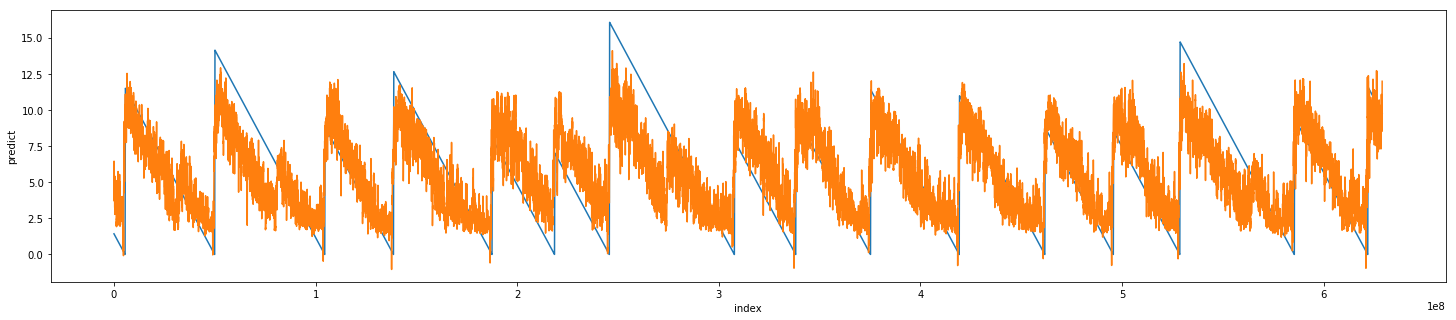

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(25,5))
df_valid_pred = df_trial.loc[112]['df_valid_pred']
sns.lineplot(x=df_train['index'], y=df_train.y)
sns.lineplot(x=df_valid_pred['index'], y=df_valid_pred.predict)

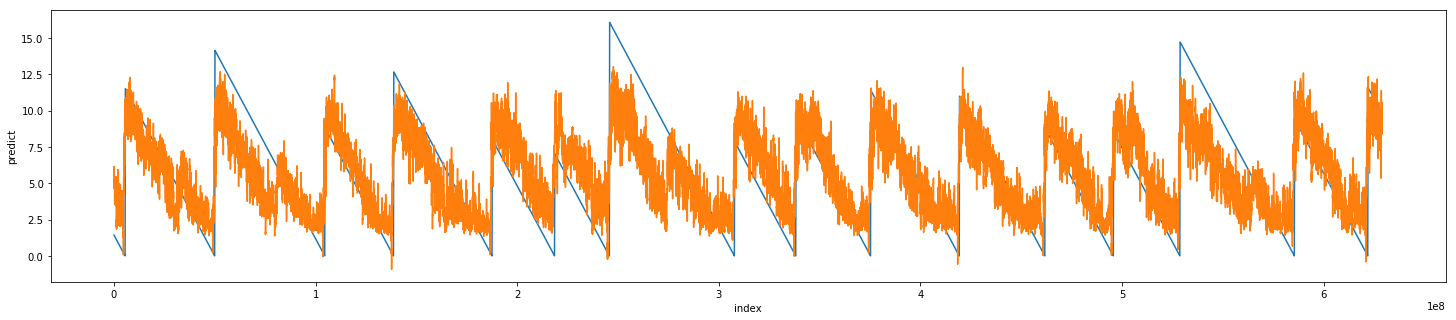

In [201]:
plt.figure(figsize=(25,5))
df_valid_pred = df_trial.loc[464]['df_valid_pred']
sns.lineplot(x=df_train['index'], y=df_train.y)
sns.lineplot(x=df_valid_pred['index'], y=df_valid_pred.predict)

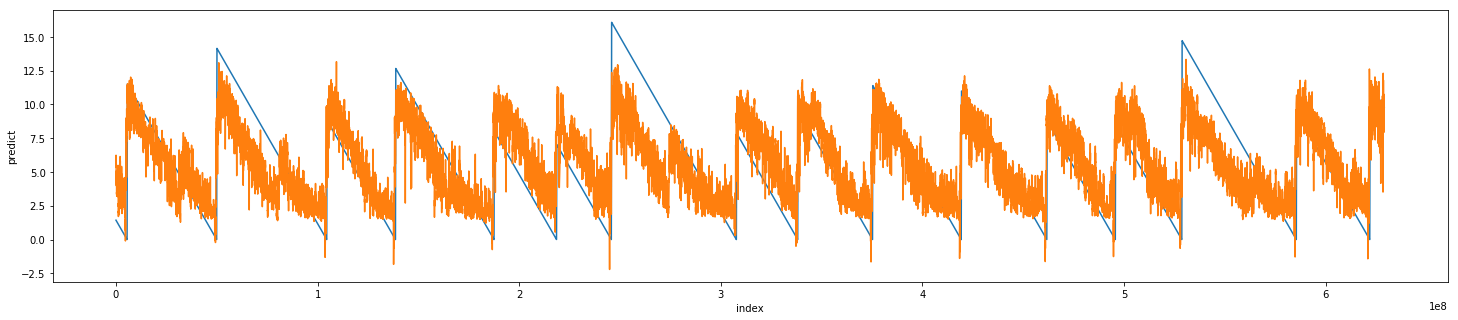

In [205]:
plt.figure(figsize=(25,5))
df_valid_pred = df_trial.loc[1398]['df_valid_pred']
sns.lineplot(x=df_train['index'], y=df_train.y)
sns.lineplot(x=df_valid_pred['index'], y=df_valid_pred.predict)

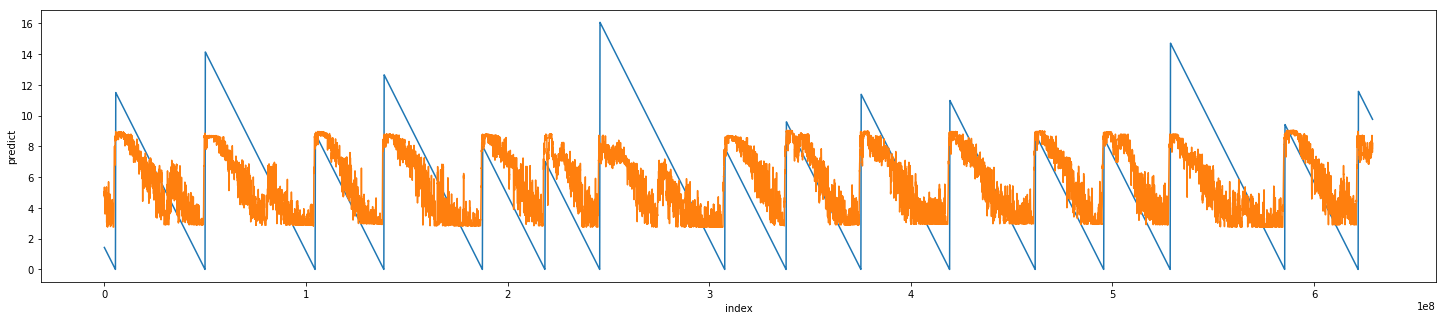

In [225]:
plt.figure(figsize=(25,5))
df_valid_pred = df_trial.loc[691]['df_valid_pred']
sns.lineplot(x=df_train['index'], y=df_train.y)
sns.lineplot(x=df_valid_pred['index'], y=df_valid_pred.predict)

In [185]:
set(columns464+columns691+columns939)

{'3th_peak_freq',
 '5000clearance_factor_quantile25',
 '5000clearance_factor_quantile75',
 '5000no_zero_crossing_mean_',
 '5000quantile99median_',
 '5000smoothness_entropy_',
 '5000smoothness_std_',
 'FFT_Mag_95q0',
 'Hilbert_mean_6',
 'MA_1000MA_std_mean_7',
 'abs_max_1',
 'abs_max_3',
 'abs_max_4',
 'abs_max_5',
 'abs_max_7',
 'abs_max_8',
 'abs_q01_4',
 'abs_q05_6',
 'abs_q05_7',
 'abs_q25_5',
 'abs_q75_6',
 'abs_q75_7',
 'ar_coefficientk_10__coeff_0',
 "autocorrelation{'lag': 5}",
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'iqr_6',
 'kurt_1',
 'kurt_2',
 'max_to_min_diff_5',
 'median__roll_std',
 "number_peaks{'n': 10}",
 'peak_to_average_power_ratio__roll_mean',
 'q01_roll_std_10',
 'q01_roll_std_1000',
 'q05_5',
 'q05_roll_std_10',
 'q05_roll_std_100',
 'q05_roll_std_1000',
 'q25_roll_std_100',
 'q75_roll_mean_10',
 "quantile{'q': 0.2}",
 'spkt_welch_density__coeff_25',
 'spkt_welch_density__coeff_3',
 'spkt_welch_density__coeff_42',
 'spkt_welch_

In [187]:
columns_ = columns464+columns691+columns939
common_columns = []
for col in list(set(columns_)):
    if(columns_.count(col)==3):
        common_columns.append(col)

In [209]:
common_columns

['abs_q01_4',
 'spkt_welch_density__coeff_3',
 'abs_q75_7',
 'q05_roll_std_1000',
 'q25_roll_std_100',
 "number_peaks{'n': 10}",
 'spkt_welch_densitycoeff_2',
 'abs_max_7']

In [38]:
df_trial.loc[691:691][['datetime','nfeatures', 'remark', 'kfold-type','train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,nfeatures,remark,kfold-type,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
691,2019-05-06 07:28:35.787960,25,None,group,2.100557,0.014173,2.169184,0.610749,0.068627


In [19]:
df_test_pred = df_trial.loc[2024]['df_test_pred']

In [20]:
df_submit = pd.DataFrame()
df_submit['time_to_failure'] = np.mean(df_test_pred.drop(columns=['index']).values, axis=1)
df_submit['seg_id'] = df_test_pred['index']
df_submit.to_csv('submission.csv', index=False)

In [23]:
import random
from deap import creator, base, tools, algorithms
import warnings
warnings.filterwarnings("default")
#https://deap.readthedocs.io/en/master/api/tools.html

class GAFeatureSelection(object):
    

    def __init__(self, df, features, n_component, n_population=None, tournsize=None, cxpb=.5, mutpb=.2, indpb=.05, ngen=100, rndseed=1985):
        random.seed(rndseed)
        self.df = df
        self.features = features
        self.n_component = n_component
        self.n_population = n_population
        if (self.n_population == None):
            self.n_population = self.__evalute_n_population__(self.n_component, len(self.features))
        self.tournsize = tournsize
        if (self.tournsize == None):
            self.tournsize = int(self.n_population*.01)
        self.cxpb = cxpb
        self.mutpb = mutpb
        self.indpb = indpb
        self.ngen = ngen
#         creator.create("FitnessMax", base.Fitness, weights=(1.0,),)
#         creator.create("Individual", list, fitness=creator.FitnessMax)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)
        self.toolbox = base.Toolbox()
        self.toolbox.register("attr_gen", random.randint, 0, len(self.features)-1)
        self.toolbox.register("individual", tools.initRepeat, creator.Individual, self.toolbox.attr_gen, n=self.n_component)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("evaluate", self.evaluate)
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutFlipBit, indpb=self.indpb)
        self.toolbox.register("select", tools.selTournament, tournsize=self.tournsize)
        self.population = self.toolbox.population(n=self.n_population)
        return
    
    
    def evaluate(self, individual):
        raise Exception('no inheritance')
        
        
    def run(self, ntop=1):
        for gen in range(self.ngen):
            offspring = algorithms.varAnd(self.population, self.toolbox, cxpb=self.cxpb, mutpb=self.mutpb)
            fits = self.toolbox.map(self.toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            self.population = self.toolbox.select(offspring, k=len(self.population))
        return tools.selBest(self.population, k=ntop)
    
    
    def __evalute_n_population__(self, n_component, n_features, init_n_population=100, feature_adoption_rate=.9):
        n_population = init_n_population
        selected_n_feature = 0
        while selected_n_feature/n_features < feature_adoption_rate:
            n_population = int(n_population*1.2)
            k = []
            for j in np.arange(n_population):
                k.append([random.randint(0, n_features-1) for i in np.arange(n_component)])
            k = np.array(k)
            selected_n_feature = np.unique(k).shape[0]
        return n_population
    

In [39]:
ga_trial = []
fixed_columns = ['abs_q01_4',
             'spkt_welch_density__coeff_3',
             'abs_q75_7',
             'q05_roll_std_1000',
             'q25_roll_std_100',
             "number_peaks{'n': 10}",
             'spkt_welch_densitycoeff_2',
             'abs_max_7']

class MyGAFS(GAFeatureSelection):
    
#     def __init__(self, df, features, n_component, **kwargs):
#         super(MyGAFS, self).__init__(df, features, n_component, **kwargs)
#         return
    
    def evaluate(self, individual):
        
        select_i = [self.features[chromosome] for chromosome in individual]
        columns = fixed_columns + select_i
        
        param={
            'algorithm': {
                'cls': 'lgb.LGBMRegressor',
                'fit': {
                    'early_stopping_rounds': 200,
                    'eval_metric': 'mae',
                    'verbose': False
                },
                'init': {
                    'bagging_fraction': 0.9629636521622223,
                    'feature_fraction': 0.917549020490175,
                    'lambda_l1': 75.11011819901437,
                    'lambda_l2': 84.85130517060821,
                    'learning_rate': 0.1921537121698339,
                    'max_bin': 36,
                    'max_depth': 5,
                    'min_data_in_leaf': 687,
                    'n_jobs': 16,
                    'random_state': 9950
                }
                },
            'columns': columns,
            'feature_importance': {
                'is_output': False,
                'permutation_feature_importance': False,
                'permutation_random_state': 1
            },
            'kfold': {
                'n_splits': 8,
                'random_state': 1985,
                'shuffle': True,
                'type': 'group'
            },
            'scaler': {
                'cls': 'StandardScaler'
            }
        }
        
        score = []
        try:
            df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train, param, df_test = None, trial=ga_trial, remark=None)
            val_mae_mean = np.mean(df_his.valid)
            val_mae_var = np.var(df_his.valid)
            train_mae_mean = np.mean(df_his.train)
            train_mae_var = np.var(df_his.train)
        except Exception as e:
            print(e.__str__())
            return 0
        fitness = np.abs(val_mae_mean-train_mae_mean)*val_mae_mean
        return fitness,

In [ ]:
gafs = MyGAFS(df = df_train,  features = df_train[tsfresh_columns].columns.drop(fixed_columns).tolist(),  n_component = 17,  ngen = 10,  n_population = 10000)
top10 = gafs.run(10)

/home/ubuntu/.conda/envs/py36/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/ubuntu/.conda/envs/py36/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


KeyboardInterrupt: 

In [5]:
len(df_train)

NameError: name 'df_train' is not defined